# NYC Public Parks Toilets Analysis
## by [Dan Hillman](http://danhillman.dev)
### 1. What is this analysis for?
While looking for datasets in the [NYC Open Data website](https://opendata.cityofnewyork.us/), the word "toilets" caught my attention. It is a simple dataset to practice data cleaning on, and it does not appear to have been given a lot of attention. Thought it'd be a great addition to my portfolio as well as good practice.
### 2. Where can the data be found?
The data download can be found [here](https://data.cityofnewyork.us/Recreation/Directory-Of-Toilets-In-Public-Parks/hjae-yuav).
### 3. What insights have you gotten out of this analysis?
~17.99% of toilets in NYC public parks are handicap-accessible and currently operational. After some research, 11.3% of New Yorkers report having a disability. The 17.99% of handicap-accessible toilets makes sense considering 11.3% of the New York population reports having a disability. 

There isn't much else to get out of this dataset other than a borough-level exploration of what toilets are open year-round or are handicap accessible. It's possible you could parse the "Location" column and possibly get some meaningful data, but it did not seem necessary to go that deep.
### 4. What skills did you learn from performing this analysis?
The `df.join()` method came in handy to combine the `borough_areas` DataFrame and the `toilets_pivot` DataFrame. `df.join()` is good for combining DataFrames on the index as opposed to using `df.merge()` where one must join "on" a specific column.

## Data Cleaning and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

toilets = pd.read_csv("Directory_Of_Toilets_In_Public_Parks.csv")

In [2]:
toilets.head()

,Name,Location,Open Year-Round,Handicap Accessible,Borough,Comments
0,100% Playground,"Glenwood Road, East 100 & East 101 streets",Yes,NaN,Brooklyn,NaN
1,174th Street Playground,"East 174 Street, Stratford Avenue, Bronx River...",Yes,NaN,Bronx,NaN
2,227 Street Playground,Bronx Boulevard between East 226 and East 228 ...,Yes,Yes,Bronx,NaN
3,Abe Lincoln,"East 135 Street, between Madison & 5 avenues",Yes,NaN,Manhattan,NaN
4,Abigail Playground,"East 156 Street, Tinton Avenue",No,NaN,Bronx,NaN


### `toilets` DataFrame Overview

In [3]:
toilets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 6 columns):
Name                   616 non-null object
Location               615 non-null object
Open Year-Round        589 non-null object
Handicap Accessible    129 non-null object
Borough                616 non-null object
Comments               8 non-null object
dtypes: object(6)
memory usage: 29.0+ KB


The `Location` column will be explored first to determine if any address-related data or coordinate-related data can be parsed. The `Borough` column will then be explored and determined if it is more appropriate for use in this analysis.

In [4]:
toilets_copy = toilets.copy()

### "Location" Column Exploration

In [5]:
toilets_copy.loc[:,"Location"].value_counts(dropna=False)[0:6]

Bruckner Boulevard, Eastchester Bay, Hutchinson                                                    6
Broadway, Jerome Avenue, City Line, Van Cortlandt Park South                                       4
Richmond Parkway & Moravian Cemetery at Rockland Avenue                                            4
South of Flushing Avenue                                                                           3
Natural Area and Boardwalk from Sands Lane to Vulcan Street, East of Father Capodanno Boulevard    3
Central Park                                                                                       2
Name: Location, dtype: int64

The "Location" column contains address information in an inconsistent format that can't be parsed easily. The focus will remain on number of toilets at borough level.

### "Borough" Column

In [6]:
toilets_copy.loc[:,"Borough"].value_counts(dropna=False)

Brooklyn         170
Queens           161
Manhattan        129
Bronx            118
Staten Island     38
Name: Borough, dtype: int64

The "Borough" column will be more appropriate for this analysis. The number of public parks toilets per square mile in each borough will be evaluated.

#### Borough Areas in mi<sup>2</sup>

In [7]:
borough_areas_data = {"area_sq_mi":[22.82,69.50,58.69,42.47,108.10]}
borough_areas_index = ["Manhattan","Brooklyn","Staten Island","Bronx","Queens"]
borough_areas = pd.DataFrame(data=borough_areas_data,index=borough_areas_index)
borough_areas

,area_sq_mi
Manhattan,22.82
Brooklyn,69.50
Staten Island,58.69
Bronx,42.47
Queens,108.10


The area in square miles for each borough was found in a Google search on 10 August 2019. These values will be used later to calculate the ratio of public parks toilets to square miles for each borough.

### "Handicap Accessible" Column

In [8]:
toilets_copy.loc[:,"Handicap Accessible"].value_counts(dropna=False)

NaN    487
Yes    129
Name: Handicap Accessible, dtype: int64

The values in the "Handicap Accessible" column can be safely assumed to be Boolean. The `NaN` values will be converted to `False`, and the `Yes` values will be converted to `True`.

In [9]:
handicap_access_bool = toilets_copy.loc[:,"Handicap Accessible"] == "Yes"
toilets_copy.loc[handicap_access_bool,"Handicap Accessible"] = True
toilets_copy.loc[~handicap_access_bool,"Handicap Accessible"] = False
toilets_copy.loc[:,"Handicap Accessible"] = toilets_copy.loc[:,"Handicap Accessible"].astype("bool")

toilets_copy.loc[:,"Handicap Accessible"].value_counts(dropna=False)

False    487
True     129
Name: Handicap Accessible, dtype: int64

### "Open Year-Round" Column

In [10]:
toilets_copy.loc[:,"Open Year-Round"].value_counts(dropna=False)

Yes    529
No      60
NaN     27
Name: Open Year-Round, dtype: int64

Rows with `NaN` in the "Open Year-Round" column can't be assumed to be treated as `False`. The rows with "NaN" values in the "Open Year-Round" column will be dropped for simplicity's sake. The `Yes` and `No` values will be converted to Boolean values.

In [11]:
toilets_copy.dropna(subset=["Open Year-Round"],inplace=True)
open_year_round_bool = toilets_copy.loc[:,"Open Year-Round"] == "Yes"
toilets_copy.loc[open_year_round_bool,"Open Year-Round"] = True
toilets_copy.loc[~open_year_round_bool,"Open Year-Round"] = False
toilets_copy.loc[:,"Open Year-Round"] = toilets_copy.loc[:,"Open Year-Round"].astype("bool")

toilets_copy.loc[:,"Open Year-Round"].value_counts(dropna=False)

True     529
False     60
Name: Open Year-Round, dtype: int64

### "Comments" Column

In [12]:
comments_exist_bool = pd.notnull(toilets_copy.loc[:,"Comments"])
toilets_copy.loc[comments_exist_bool,"Comments"].value_counts(dropna=False)

This facility is currently closed      5
This facility is currently closed.     1
Name: Comments, dtype: int64

A new column named "Currently Open" will be created to show a toilet's operational status. The columns listed as "currently closed" will be given a value of `False` in the "Currently Open" column.

In [13]:
closed_bool = toilets_copy.loc[:,"Comments"].str.contains("currently closed",na=False)
toilets_copy.loc[closed_bool,"Currently Open"] = False
toilets_copy.loc[~closed_bool,"Currently Open"] = True
toilets_copy.loc[:,"Currently Open"] = toilets_copy.loc[:,"Currently Open"].astype("bool")

toilets_copy.loc[:,"Currently Open"].value_counts(dropna=False)

True     583
False      6
Name: Currently Open, dtype: int64

### Data Cleaning Complete

In [14]:
toilets_copy.head()

,Name,Location,Open Year-Round,Handicap Accessible,Borough,Comments,Currently Open
0,100% Playground,"Glenwood Road, East 100 & East 101 streets",True,False,Brooklyn,NaN,True
1,174th Street Playground,"East 174 Street, Stratford Avenue, Bronx River...",True,False,Bronx,NaN,True
2,227 Street Playground,Bronx Boulevard between East 226 and East 228 ...,True,True,Bronx,NaN,True
3,Abe Lincoln,"East 135 Street, between Madison & 5 avenues",True,False,Manhattan,NaN,True
4,Abigail Playground,"East 156 Street, Tinton Avenue",False,False,Bronx,NaN,True


In [15]:
cleaned_toilets = toilets_copy.copy()
cleaned_toilets.drop(["Name","Location","Comments","Open Year-Round"],axis=1,inplace=True)

The "Name", "Location", and "Comments" columns are dropped because they are not relevant to the analysis.

In [16]:
cleaned_toilets.loc[:,"Open and Handicap Accessible"] = cleaned_toilets.loc[:,"Currently Open"] & \
                                                        cleaned_toilets.loc[:,"Handicap Accessible"]

cleaned_toilets.head()

,Handicap Accessible,Borough,Currently Open,Open and Handicap Accessible
0,False,Brooklyn,True,False
1,False,Bronx,True,False
2,True,Bronx,True,True
3,False,Manhattan,True,False
4,False,Bronx,True,False


In [17]:
cleaned_toilets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589 entries, 0 to 615
Data columns (total 4 columns):
Handicap Accessible             589 non-null bool
Borough                         589 non-null object
Currently Open                  589 non-null bool
Open and Handicap Accessible    589 non-null bool
dtypes: bool(3), object(1)
memory usage: 10.9+ KB


`cleaned_toilets` is ready to be analyzed.

## Analysis and Visualization

In [18]:
toilets_pivot = pd.pivot_table(cleaned_toilets,
                               index="Borough",
                               values=["Handicap Accessible",
                                       "Currently Open",
                                       "Open and Handicap Accessible"],
                               aggfunc=[np.mean,np.sum],
                               margins=True)
toilets_pivot

mean                                                   \
              Currently Open Handicap Accessible Open and Handicap Accessible   
Borough                                                                         
Bronx               1.000000            0.222222                     0.222222   
Brooklyn            0.993865            0.147239                     0.147239   
Manhattan           1.000000            0.206612                     0.206612   
Queens              0.993506            0.116883                     0.116883   
Staten Island       0.882353            0.470588                     0.382353   
All                 0.989813            0.185059                     0.179966   

                         sum                                                   
              Currently Open Handicap Accessible Open and Handicap Accessible  
Borough                                                                        
Bronx                  117.0                26.0                         26.0  
Brooklyn               162.0                24.0                         24.0  
Manhattan              121.0                25.0                         25.0  
Queens                 153.0                18.0                         18.0  
Staten Island           30.0                16.0                         13.0  
All                    583.0               109.0                        106.0

`toilets_pivot` gives an excellent view of what percent of toilets are open and handicap-accessible for each borough. Notice the low percentage of bathrooms currently open and handicap accessible.

Worth noting is the low percentage of handicap accessible toilets overall (~18.5%).

In [19]:
borough_areas = borough_areas.join(toilets_pivot.loc[:,"sum",]["Currently Open"])
borough_areas.loc[:,"Currently Open Toilets/Sq. Mile"] = borough_areas.loc[:,"Currently Open"] / \
                                          borough_areas.loc[:,"area_sq_mi"]

borough_areas = borough_areas.join(toilets_pivot.loc[:,"sum",]["Open and Handicap Accessible"])
borough_areas.loc[:,"Open and Handicap Accessible Toilets/Sq. Mile"] = borough_areas.loc[:,"Open and Handicap Accessible"] / \
                                          borough_areas.loc[:,"area_sq_mi"]
borough_areas

,area_sq_mi,Currently Open,Currently Open Toilets/Sq. Mile,Open and Handicap Accessible,Open and Handicap Accessible Toilets/Sq. Mile
Manhattan,22.82,121.0,5.302366,25.0,1.095530
Brooklyn,69.50,162.0,2.330935,24.0,0.345324
Staten Island,58.69,30.0,0.511160,13.0,0.221503
Bronx,42.47,117.0,2.754886,26.0,0.612197
Queens,108.10,153.0,1.415356,18.0,0.166512


The sum of currently open, handicap accessible, and open year-round toilets for each borough is joined with the `borough_areas` DataFrame from earlier in this analysis.

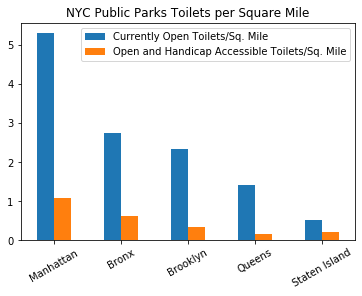

In [20]:
toilets_viz = borough_areas.loc[:,["Currently Open Toilets/Sq. Mile",
                                   "Open and Handicap Accessible Toilets/Sq. Mile"]].copy()
toilets_viz = toilets_viz.sort_values(by="Currently Open Toilets/Sq. Mile",ascending=False)

ax = toilets_viz.plot(kind="bar",rot=30)
ax.set_title("NYC Public Parks Toilets per Square Mile")
plt.show()

The number of currently open, handicap accessible toilets in public parks is dwarfed by the number of public parks toilets that are currently open but may or may not have ADA compliant accomodations.

## Thoughts and Conclusions

A possible cause for the low percentage of handicap accessible toilets is the increased cost associated with constructing and maintaining an ADA compliant restroom. 

[This article](https://www.buildings.com/article-details/articleid/9242/title/the-ada-compliant-restroom) explains the requirements needed to construct an ADA compliant restroom.

Addtionally, one can surmise each borough provides ADA compliant toilets based on the number of handicapped residents in its population.

According to [this article](https://www.riemerlawfirm.com/wiki/new-york-disability-statistics), 11.3% of New Yorkers have a disability as of 2015:

11.3% fits with the percentage of toilets in each borough that is handicap accessible.